# Insert landGRIDS-derived soil class in SUMMA set up
Inserts mode soil class of each HRU into the attributes `.nc` file. The intersection code stores a histogram of soil classes in fields `USGS_{0,1,...,12}`.

In [1]:
# modules
import os
import numpy as np
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime
from utils.read_files import read_from_control, make_default_path

#### Control file handling

In [2]:
# Store the name of the 'active' file in a variable
controlFile = 'control_EastRiver.txt'
averaging_type = 'majority'

#### Find shapefile location and name

In [3]:
# Path to and name of shapefile with intersection between catchment and land classes
intersect_path = read_from_control(controlFile,'intersect_land_path')
intersect_name = read_from_control(controlFile,'intersect_land_name')

In [4]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_veg', controlFile) # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()


In [5]:
# Variable names used in shapefile
intersect_hruId_var = read_from_control(controlFile,'catchment_shp_hruid')

#### Find where the attributes file is

In [6]:
# Attribute path & name
attribute_path = read_from_control(controlFile,'settings_summa_path')
attribute_name = read_from_control(controlFile,'settings_summa_attributes')

In [7]:
# Specify default path if needed
if attribute_path == 'default':
    attribute_path = make_default_path('settings/SUMMA', controlFile) # outputs a Path()
else:
    attribute_path = Path(attribute_path) # make sure a user-specified path is a Path()

#### Open the files and fill the placeholder values in the attributes file

In [8]:
# Open files
shp = gpd.read_file(intersect_path/intersect_name)

In [9]:
if averaging_type == 'histogram':
    # Open the netCDF file for reading/writing
    with nc4.Dataset(attribute_path / attribute_name, "r+") as att:
    
        # Keep track of number of water (class 11 in NLCD) occurrences
        is_water = 0
        
        # Loop over the HRUs in the attributes
        for idx in range(len(att['hruId'])):
            
            # Find the HRU ID (attributes file) at this index
            attribute_hru = att['hruId'][idx]
        
            # Find the row in the shapefile that contains info for this HRU
            shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
            
            # Extract the histogram values
            tmp_hist = []
            for j in range(1, 22):  # NLCD classes range from 11 to 95 (skipping numbers in between)
                if f'landcover_{j}' in shp.columns:
                    tmp_hist.append(shp[f'landcover_{j}'][shp_mask].values[0])
                else:
                    tmp_hist.append(0)
            
            # Find the index with the most occurrences
            tmp_lc = np.argmax(np.asarray(tmp_hist)) + 1  # Adjusting to match land cover classes
            
            # Check the assumption that index == land class
            if shp[f'landcover_{tmp_lc}'][shp_mask].values != tmp_hist[tmp_lc - 1]:
                print(f'Index and mode land class do not match at hru_id {shp[intersect_hruId_var][shp_mask].values[0]}')
                tmp_lc = -999  # Assigning a missing value indicator
            
            # Handle the case where we have water (NLCD = 11)
            if tmp_lc == 11:
                if any(val > 0 for val in tmp_hist[:10] + tmp_hist[11:]):  # Check if other land classes are present
                    tmp_lc = np.argmax(np.asarray(tmp_hist[:10] + tmp_hist[11:])) + 1  # Select 2nd-most common class
                else:
                    is_water += 1  # HRU is exclusively water
            
            # Replace the value in the attributes file
            print(f'Replacing land class {att["vegTypeIndex"][idx]} with {tmp_lc} at HRU {attribute_hru}')
            att['vegTypeIndex'][idx] = tmp_lc
            
        # Print water counts
        print(f'{is_water} HRUs were identified as containing only open water. Note that SUMMA skips hydrologic calculations for such HRUs.')
else:
    # Open the netcdf file for reading+writing
    with nc4.Dataset(attribute_path/attribute_name, "r+") as att:    
        # Loop over the HRUs in the attributes
        for idx in range(0,len(att['hruId'])):
            
            # Find the HRU ID (attributes file) at this index
            attribute_hru = att['hruId'][idx]
        
            # Find the row in the shapefile that contains info for this HRU
            shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
            
            # Extract the histogram values
            tmp_majority = []
            if 'landcove_1' in shp.columns:
                tmp_majority.append(shp['landcove_1'][shp_mask].values[0])
            else:
                tmp_majority.append(-999)
            
            # Find the index with the most occurences
            # Note: this assumes that we have USGS_0 to USGS_12 and thus that index == landclass. 
            tmp_sc = np.asarray(tmp_majority)
            
            # Check the assumption that index == landclass
            if shp['landcove_1'][shp_mask].values != tmp_sc[0]:
                print('Index and mode land class do not match at hru_id ' + \
                    str(shp[intersect_hruId_var][shp_mask].values[0]))
                tmp_sc = -999
                
            # Replace the value
            print('Replacing land class {} with {} at HRU {}'.format(att['vegTypeIndex'][idx],tmp_sc,attribute_hru))
            att['vegTypeIndex'][idx] = tmp_sc

Replacing land class 52 with [6.] at HRU 0
Replacing land class 42 with [1.] at HRU 1
Replacing land class 52 with [6.] at HRU 2


## Check

In [10]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
# Open the files 
shp = gpd.read_file(intersect_path/intersect_name)
att = xr.open_dataset(attribute_path/attribute_name)

In [12]:
# Set HRU IDs as index in the shape
shp = shp.set_index(intersect_hruId_var)

In [13]:
# Sort the shape to match the order of the attributes
shp = shp.loc[att['hruId'].values]

In [14]:
# temporarily store the vegtype in the shape for plotting
shp['vegTypeIndex'] = att['vegTypeIndex'][:]

In [15]:
shp['vegTypeIndex']

HRU_ID
0    6
1    1
2    6
Name: vegTypeIndex, dtype: int32

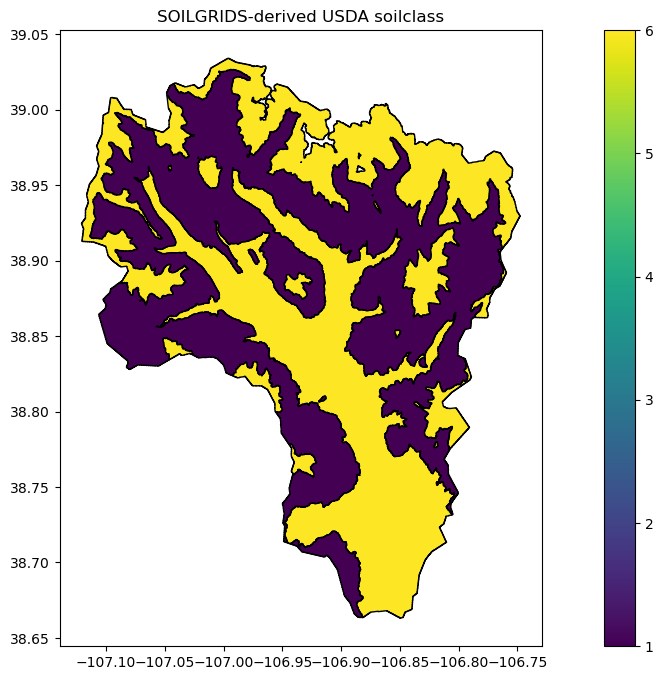

In [16]:
# Make a bplot to see what we did
shp.plot(column='vegTypeIndex',figsize=(16,8), legend=True,edgecolor='k')
ax = plt.gca()
ax.set_title('SOILGRIDS-derived USDA soilclass');

In [17]:
# Close the netCDF file
att.close()